<a href="https://colab.research.google.com/github/michellepi/MIC-Project-B/blob/main/Mini_Project_Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project Part B
### __Deadline: 25 April 2022 4pm__

__Intructions:__ Solve all the questions in this notebook. For each question you are asked to write comments in a markdown cells. You will not be given marks if you do not comment your work. Adhere to the word limit.

__Submission:__ Submit the solved notebook on KEATS. Do not submit any other files. All answers and images must be visible in your submitted notebook, we will not rerun your code. Your code must be clear and concise, you may loose marks for lenghty redundand code.

__Grading:__ Marks for this part of the project will be converted to __30% of your final grade__.

__Contact:__ If instructions are not clear, please e-mail maria.deprez@kcl.ac.uk and alena.uus@kcl.ac.uk. Do not e-mail questions about *how* you should solve this coursework, as you are assessed for your independent work.

## Dataset
You are given 60 neonatal MRI images with tissue labels, 30 term and 30 preterm. The dataset has been split to training set (25 term and 25 preterm subjects) and test set (5 term and 5 preterm subjects). The labels have been obtained using the dHCP pipeline (https://doi.org/10.1016/j.neuroimage.2018.01.054). Download your dataset from KEATS.

Here we visualise one preterm and one term training subject, and an example of the tissue segmentation.

In [1]:
# If using COLAB insert here your code to install simple ITK and mount google drive
from google.colab import drive
drive.mount('/content/drive')
!pip install SimpleITK

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/Part B Assignment
Term baby


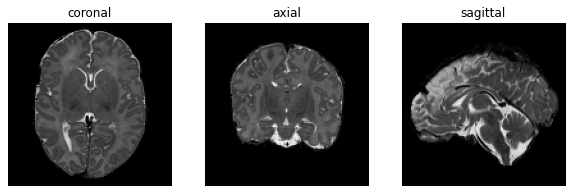

In [2]:
# Display an example term dataset (amend path as needed)
%cd '/content/drive/MyDrive/Part B Assignment'
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import sys
from display import Display3D
from registration import AffineRegistration
from registration import resample_image
from sklearn.mixture import GaussianMixture
from segmentation import Dice
from segmentation import Hausdorff
from segmentation import create_segmentation
from segmentation import gauss
from segmentation import Dice
from segmentation import Hausdorff

term_image_name = 'training data/dhcp-term/t2/sub-CC00056XX07_ses-10700.nii.gz'
sitk_image_term = sitk.ReadImage(term_image_name, sitk.sitkFloat32)
Display3D(sitk_image_term)
print('Term baby')

Preterm baby


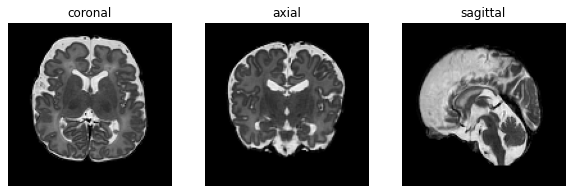

In [3]:
# Display an example preterm dataset (amend path as needed)
preterm_image_name = 'training data/dhcp-preterm/t2/sub-CC00112XX05_ses-37001.nii.gz'
sitk_image_preterm = sitk.ReadImage(preterm_image_name, sitk.sitkFloat32)
Display3D(sitk_image_preterm)
print('Preterm baby')

Preterm baby with labels


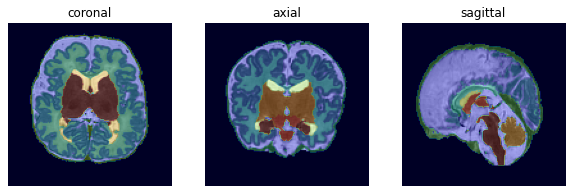

In [4]:
# Display an example segmentation (amend path as needed)
from display import PlotOverlay3D
preterm_labels_name = 'training data/dhcp-preterm/labels/sub-CC00112XX05_ses-37001.nii.gz'
sitk_labels_preterm = sitk.ReadImage(preterm_labels_name, sitk.sitkFloat32)
PlotOverlay3D(sitk_image_preterm,sitk_labels_preterm,0.3,'jet')
print('Preterm baby with labels')

## Question 1 [40 marks]
#### Implement your own segmentation technique for neonatal brain MRI
* Use a __classical method__ from weeks 1-5. 
* Focus on segmenting only the __test__ MRI images for this task
* You will be marked for scientific rigour, segmentation quality and originality.

__Task 1.1__: Segment the test dataset

In [5]:
import os
def load_data(dir_path):
  image_dir = dir_path + "/t2/"
  label_dir = dir_path + "/labels/"
  image_name = os.listdir(image_dir)

  images = []
  labels = []
  for path in image_name:
    image_path = image_dir + path
    label_path = label_dir + path
    print("Processing:", image_path)
    # Loading image
    sitk_image = sitk.ReadImage(image_path, sitk.sitkFloat32)
    sitk_label = sitk.ReadImage(label_path, sitk.sitkFloat32)
    # store all images
    images.append(sitk_image)
    labels.append(sitk_label)

  return images, labels

In [6]:
preterm_test_path = 'test data/dhcp-preterm'
term_test_path = 'test data/dhcp-term'
pt_test_im, pt_test_lbl = load_data(preterm_test_path)
t_test_im, t_test_lbl = load_data(term_test_path)

Processing: test data/dhcp-preterm/t2/sub-CC00955XX15_ses-39730.nii.gz
Processing: test data/dhcp-preterm/t2/sub-CC00867XX18_ses-8930.nii.gz
Processing: test data/dhcp-preterm/t2/sub-CC00946XX23_ses-26330.nii.gz
Processing: test data/dhcp-preterm/t2/sub-CC00933XX18_ses-20530.nii.gz
Processing: test data/dhcp-preterm/t2/sub-CC00838XX22_ses-30610.nii.gz
Processing: test data/dhcp-term/t2/sub-CC00992XX20_ses-62530.nii.gz
Processing: test data/dhcp-term/t2/sub-CC00949XX26_ses-55630.nii.gz
Processing: test data/dhcp-term/t2/sub-CC00714XX13_ses-240900.nii.gz
Processing: test data/dhcp-term/t2/sub-CC00596XX20_ses-190100.nii.gz
Processing: test data/dhcp-term/t2/sub-CC00622XX12_ses-185600.nii.gz


Test preterm example


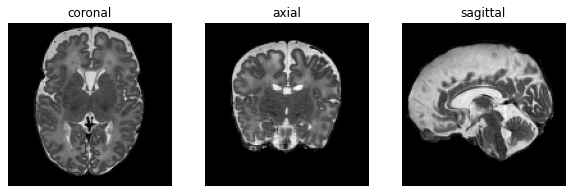

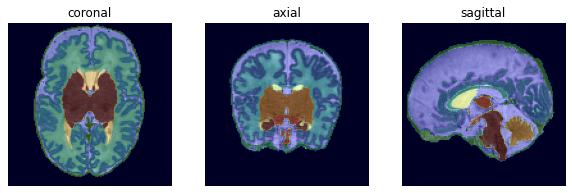

Test term example


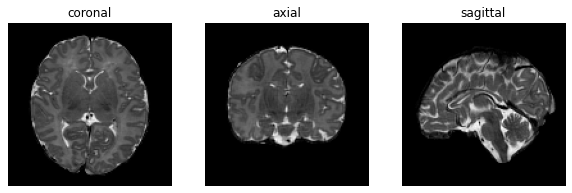

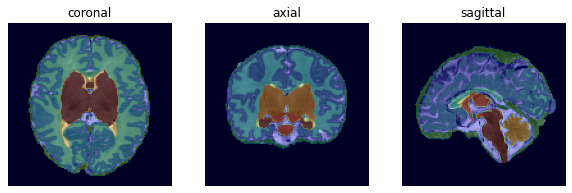

In [7]:
pt_ex = pt_test_im[0]
pt_exl = pt_test_lbl[0]
t_ex = t_test_im[0]
t_exl = t_test_lbl[0]
print('Test preterm example')
Display3D(pt_ex)
PlotOverlay3D(pt_ex, pt_exl, 0.3, 'jet')
plt.show()
print('Test term example')
Display3D(t_ex)
PlotOverlay3D(t_ex, t_exl, 0.3, 'jet')

T2 atlas


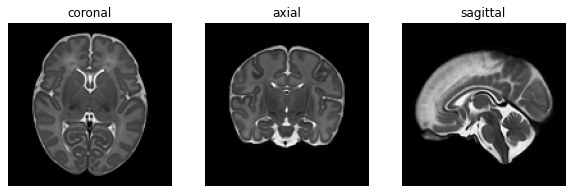

T2 atlas over example preterm brain


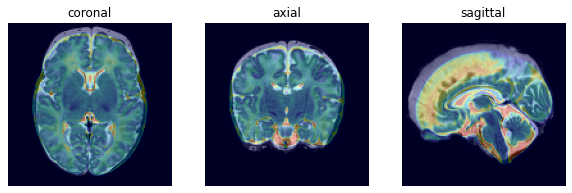

T2 atlas over example term brain


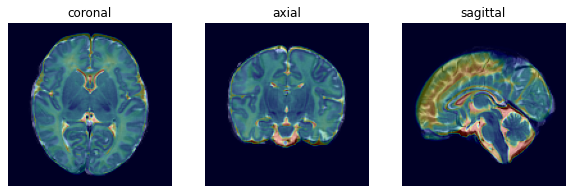

In [8]:
# Your code here
atlas_mask = sitk.ReadImage('Probabilistic_atlas/atlas-brain-mask.nii.gz', sitk.sitkFloat32)
t2_atlas = sitk.ReadImage('Probabilistic_atlas/atlas-t2.nii.gz', sitk.sitkFloat32)
label_atlas = sitk.ReadImage('Probabilistic_atlas/atlas-labels.nii.gz', sitk.sitkFloat32)

print("T2 atlas")
Display3D(t2_atlas)
plt.show()
print("T2 atlas over example preterm brain")
PlotOverlay3D(pt_ex, t2_atlas, 0.3, 'jet')
plt.show()
print("T2 atlas over example term brain")
PlotOverlay3D(t_ex, t2_atlas, 0.3, 'jet')


In [9]:
# import functions from registration.py
from registration import AffineRegistration
from registration import resample_image

def register_images(images, t2_atlas):

  trans = []
  for i, im in enumerate(images):
    trans.append(AffineRegistration(im, t2_atlas))

  return trans

t_trans = register_images(t_test_im, t2_atlas)
pt_trans = register_images(pt_test_im, t2_atlas)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55
Iteration  56
-------
itk::simple::Transform
 AffineTransform (0x2398380)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 3
   Modified Time: 7295
   Debug: Off
   Object Name: 
   Observers: 
     non

atlas-prob-lab-01.nii.gz


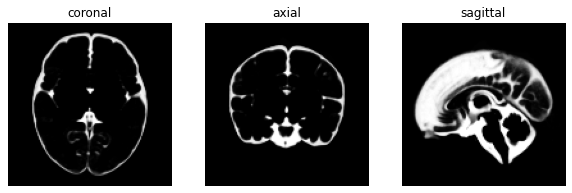

atlas-prob-lab-02.nii.gz


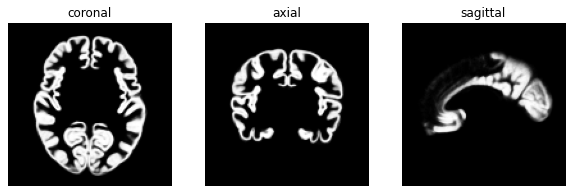

atlas-prob-lab-03.nii.gz


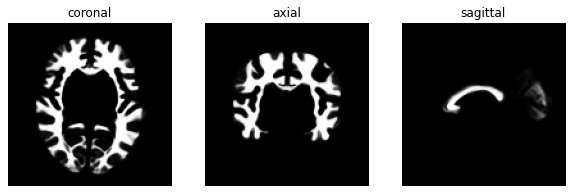

atlas-prob-lab-04.nii.gz


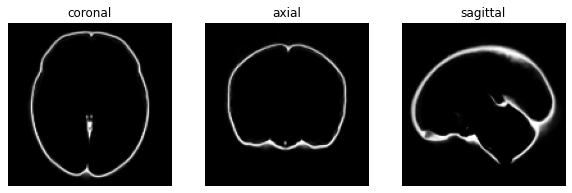

atlas-prob-lab-05.nii.gz


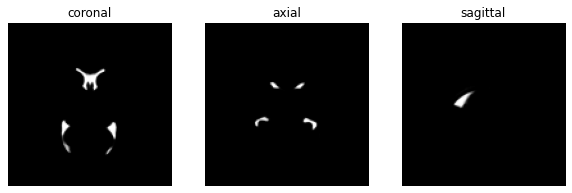

atlas-prob-lab-06.nii.gz


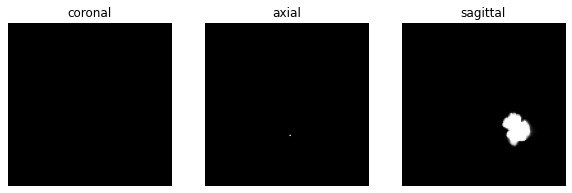

atlas-prob-lab-07.nii.gz


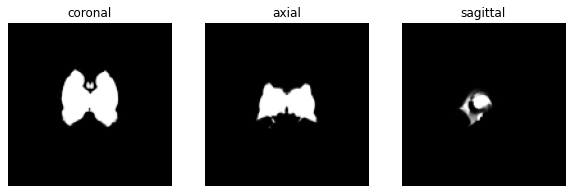

atlas-prob-lab-08.nii.gz


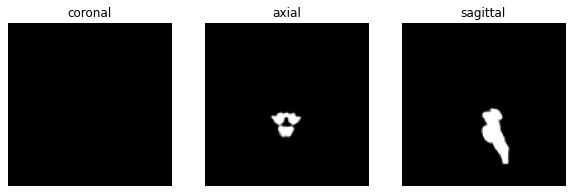

atlas-prob-lab-09.nii.gz


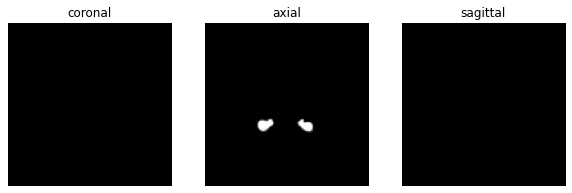

In [10]:
prob_dir = 'Probabilistic_atlas/label-probabilities/'
prob_paths = os.listdir(prob_dir)
prob_paths.sort()

prob_maps = []
for path in prob_paths:
    print(path)
    map = sitk.ReadImage(prob_dir + path, sitk.sitkFloat32)
    Display3D(map)
    plt.show()
    prob_maps.append(map)

In [11]:
def resample_labels(original, images, trans):
  resampled = []
  for i,ori in enumerate(original):
    probs = []
    for im in images:
      im_res = resample_image(ori, im, transformation=trans[i])
      probs.append(im_res)
    resampled.append(probs)
  return resampled

t_priors = resample_labels(t_test_im, prob_maps, t_trans)
pt_priors = resample_labels(pt_test_im, prob_maps, pt_trans)

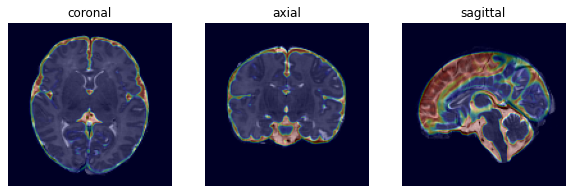

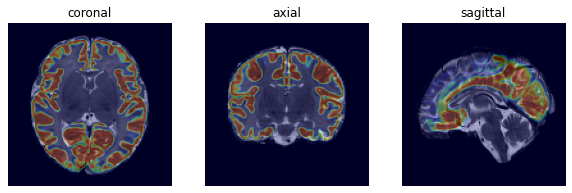

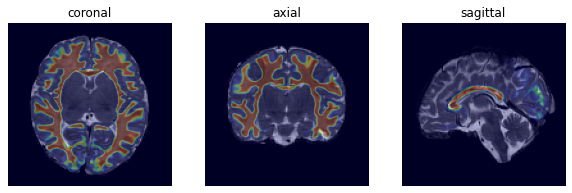

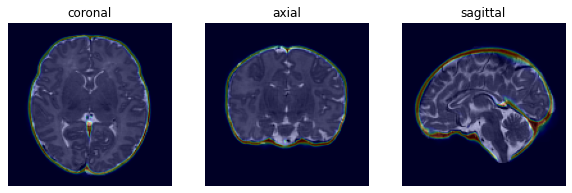

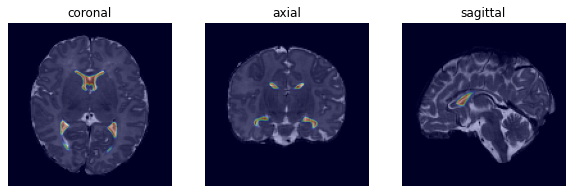

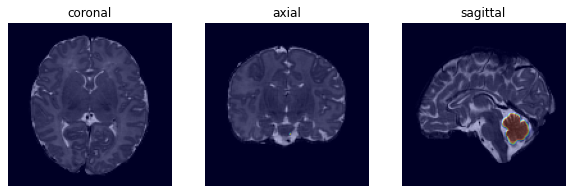

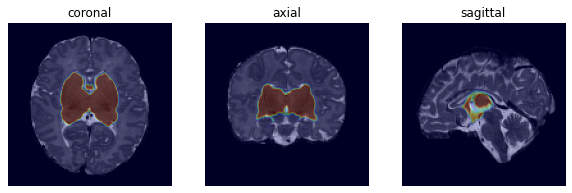

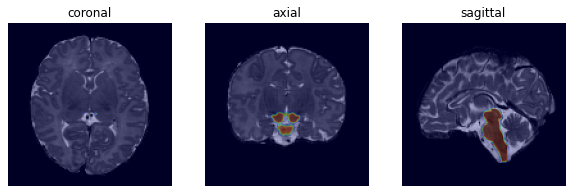

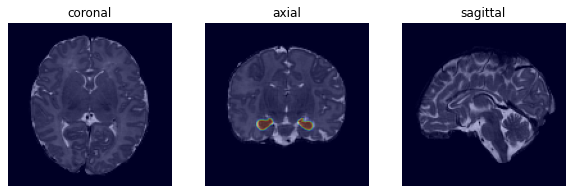

In [12]:
for l in t_priors[0]:
  PlotOverlay3D(t_test_im[0], l, 0.3,c='jet')

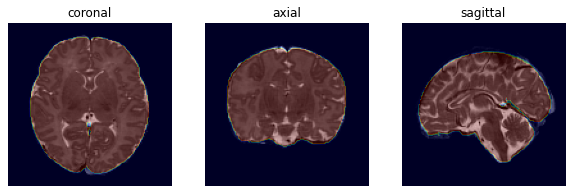

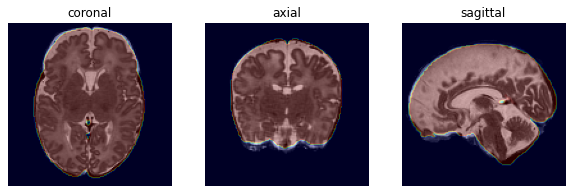

In [13]:
def resample(original, image, transformation):
  resampled = []
  for i, ori in enumerate(original):
    im_res = resample_image(ori, image, transformation=transformation[i])
    resampled.append(im_res)
  return resampled

t_masks = resample(t_test_im, atlas_mask, transformation = t_trans)
pt_masks = resample(pt_test_im, atlas_mask, transformation = pt_trans)
PlotOverlay3D(t_test_im[0], t_masks[0], 0.3,c='jet')
plt.show()
PlotOverlay3D(pt_test_im[0], pt_masks[0], 0.3,c='jet')

In [14]:
def mask_image(sitk_image, mask):
  image = sitk.GetArrayFromImage(sitk_image)
  mask = sitk.GetArrayFromImage(mask)

  mask[mask>=0.5]=1
  mask[mask<0.5]=0

  image_masked = image*mask

  return image_masked

def update_parameters_EM(features,p):
    n=p.shape[0]
    means=np.zeros(9)
    variances=np.zeros(9)
    for k in range(0,9):
        means[k]=np.sum(p[:,k]*features.flatten())/np.sum(p[:,k])
        variances[k]=np.sum(p[:,k]*(features.flatten()-means[k])**2)/np.sum(p[:,k])

    return means,variances

def update_probability_EM(features,means,variances, a): 
    p=np.zeros([features.shape[0],9])
    for k in range(9):
        p[:,k] = gauss(features.flatten(),means[k],variances[k])*a[:,k]  #mix[k]
    denom = np.matlib.repmat(np.sum(p,1), 9, 1).T
    p=p/denom
    return p
    
    return p

def gmm_seg(image, sitk_image, priors):
  ind = np.where(image>0)
  data = image[ind]
  features = data.reshape(-1,1)
  priors = [p[ind] for p in priors]
  priors = np.stack(priors, axis=1)

  means, variances = update_parameters_EM(features, priors)
  p = update_probability_EM(features,means,variances, priors)

  for i in range(50):
    p = update_probability_EM(features,means,variances, priors)
    means, variances = update_parameters_EM(features,p)
    if i%10 == 0:
      print('iteration', i)
      print('means', np.around(means,2))
      print('variances', np.around(variances,2))

  sitk_seg_EM = create_segmentation(sitk_image,ind,p)

  return sitk_seg_EM


In [15]:
def extract_region(labels,c):
    region = np.zeros_like(labels)
    region[labels==c]=1
    return region

In [26]:
term_dice = np.zeros((len(t_test_im), 9))
preterm_dice = np.zeros((len(pt_test_im), 9))

term_hd = np.zeros((len(t_test_im), 9))
preterm_hd = np.zeros((len(pt_test_im), 9))

term_ahd = np.zeros((len(t_test_im), 9))
preterm_ahd = np.zeros((len(pt_test_im), 9))

term_seg = []
preterm_seg = []

iteration 0
means [406.86 274.34 324.21 182.39 467.01 280.7  254.94 219.71 263.93]
variances [39903.29  2289.11  2321.71 17695.22 21491.63  2001.91  1160.69  1576.6
  1591.05]
iteration 10
means [406.01 251.08 337.27  65.15 457.99 277.53 253.41 213.46 254.45]
variances [31384.07   642.85  1188.17  2105.59 19619.87  1462.88   956.33  1112.33
   774.23]
iteration 20
means [398.72 250.69 336.91  51.95 458.56 277.54 253.38 213.4  254.58]
variances [32032.63   621.83  1198.    1281.06 19571.52  1460.29   955.68  1106.44
   775.08]
iteration 30
means [397.83 250.68 336.9   50.37 458.6  277.54 253.38 213.39 254.59]
variances [32136.46   620.45  1198.52  1197.75 19568.17  1460.01   955.61  1105.73
   774.96]
iteration 40
means [397.72 250.67 336.9   50.18 458.6  277.54 253.38 213.39 254.59]
variances [32149.45   620.31  1198.56  1187.96 19567.83  1459.98   955.6   1105.65
   774.93]
Dice = 0.73
Housford distance: 10.86
Average Housedorf distance: 0.34
Dice = 0.87
Housford distance: 4.24
Averag

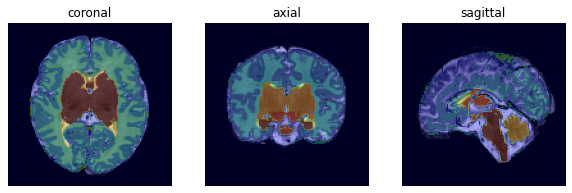

iteration 0
means [479.3  288.25 324.19 214.97 466.13 292.69 266.25 242.33 274.08]
variances [40996.79  3472.87  2519.61 31593.46 24069.85  1813.61  1469.72  2725.62
  2536.28]
iteration 10
means [503.88 255.9  341.7   93.69 460.18 290.59 262.04 232.29 262.05]
variances [27706.94   816.62  1346.12  4359.66 20667.01  1385.76   994.01  1349.11
  1069.94]
iteration 20
means [492.02 254.94 341.16  80.18 460.85 290.4  262.02 231.95 262.29]
variances [29522.58   773.43  1351.64  3344.21 20548.33  1380.59   990.37  1330.67
  1077.98]
iteration 30
means [488.26 254.87 341.11  74.54 460.99 290.34 262.02 231.87 262.28]
variances [30162.96   768.85  1352.87  2911.37 20537.42  1381.56   989.53  1326.2
  1077.09]
iteration 40
means [486.21 254.85 341.1   71.4  461.05 290.3  262.02 231.83 262.28]
variances [30520.33   766.51  1353.34  2669.27 20532.91  1382.43   989.11  1323.94
  1076.51]
Dice = 0.81
Housford distance: 10.25
Average Housedorf distance: 0.25
Dice = 0.87
Housford distance: 4.12
Averag

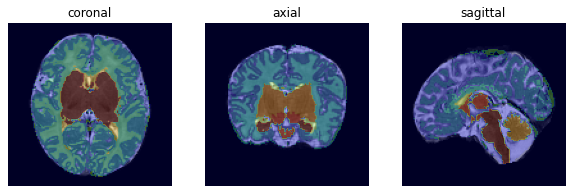

iteration 0
means [458.76 273.54 316.23 192.9  497.79 274.91 253.09 226.43 254.24]
variances [46620.59  3401.18  2561.69 29061.82 28895.32  2011.98  1174.4   1564.62
  1358.83]
iteration 10
means [464.92 242.35 334.16  66.77 491.11 272.48 251.4  222.39 249.21]
variances [35173.76   666.24  1248.3   3366.38 24954.8   1562.28   963.42  1242.48
   821.36]
iteration 20
means [455.75 242.06 333.82  54.07 491.57 272.43 251.39 222.37 249.32]
variances [36392.71   646.8   1260.88  2431.8  24931.74  1560.17   961.18  1233.08
   820.94]
iteration 30
means [454.54 242.05 333.8   52.29 491.61 272.42 251.39 222.37 249.32]
variances [36567.95   645.04  1261.62  2307.42 24929.97  1560.18   960.93  1231.93
   820.56]
iteration 40
means [454.41 242.05 333.8   52.09 491.61 272.42 251.39 222.37 249.32]
variances [36587.37   644.84  1261.7   2294.05 24929.77  1560.19   960.9   1231.81
   820.51]
Dice = 0.77
Housford distance: 11.18
Average Housedorf distance: 0.3
Dice = 0.88
Housford distance: 5.2
Average

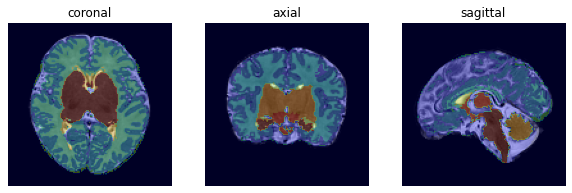

iteration 0
means [412.99 277.94 321.17 192.85 475.07 283.53 265.4  235.73 278.61]
variances [38986.66  2149.85  2210.92 22954.4  22191.64  1649.45  1110.12  1645.33
  1830.32]
iteration 10
means [414.85 255.46 333.45  65.76 472.94 281.09 263.41 229.02 272.51]
variances [31024.56   680.93  1220.05  2329.54 18982.3   1259.5    874.26  1042.68
   940.18]
iteration 20
means [408.07 255.18 333.25  52.49 473.16 281.05 263.41 228.99 272.55]
variances [31694.     665.68  1221.99  1428.23 18921.99  1263.08   873.84  1037.56
   939.19]
iteration 30
means [407.27 255.17 333.24  50.97 473.19 281.04 263.41 228.98 272.55]
variances [31795.71   664.89  1222.08  1339.57 18917.56  1264.14   873.78  1036.98
   939.17]
iteration 40
means [407.17 255.17 333.24  50.79 473.19 281.04 263.41 228.98 272.55]
variances [31808.78   664.81  1222.09  1328.72 18917.05  1264.29   873.77  1036.9
   939.17]
Dice = 0.72
Housford distance: 10.82
Average Housedorf distance: 0.36
Dice = 0.86
Housford distance: 5.1
Average

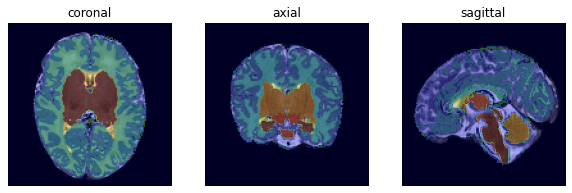

iteration 0
means [359.21 256.61 294.41 157.66 411.52 259.64 235.57 199.03 263.53]
variances [34157.35  1905.35  1485.57 16484.83 23601.6   1247.14   927.64  1107.56
  4931.99]
iteration 10
means [352.99 235.57 308.39  44.85 404.12 259.91 234.98 196.02 255.68]
variances [27408.41   503.99   714.22  1227.59 22960.86  1142.57   832.21   850.53
  3260.97]
iteration 20
means [347.45 235.38 308.19  34.24 404.51 259.91 234.97 196.03 255.75]
variances [27910.42   492.97   719.38   692.12 22954.43  1144.35   832.11   847.85
  3261.01]
iteration 30
means [346.34 235.38 308.19  32.2  404.54 259.9  234.97 196.03 255.76]
variances [28048.41   492.17   719.56   606.87 22951.67  1145.29   832.07   847.37
  3261.29]
iteration 40
means [346.04 235.38 308.19  31.67 404.55 259.9  234.97 196.03 255.77]
variances [28086.36   491.99   719.58   585.83 22950.89  1145.4    832.06   847.25
  3261.38]
Dice = 0.66
Housford distance: 10.86
Average Housedorf distance: 0.45
Dice = 0.86
Housford distance: 5.39
Avera

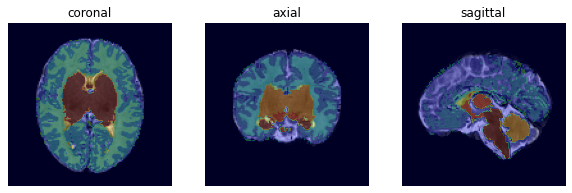

In [32]:
for i, (im, mask, p, lbl) in enumerate(zip(t_test_im, t_masks, t_priors, t_test_lbl)):
  masked_image = mask_image(im, mask)
  sitk_image_masked = sitk.GetImageFromArray(masked_image)
  sitk_image_masked.CopyInformation(im) 
  input = sitk.GetArrayFromImage(sitk_image_masked)

  prior = [sitk.GetArrayFromImage(i) for i in p]

  seg = gmm_seg(input, im, prior)
  term_seg.append(seg)
  for label in range(9):
    reg_seg = extract_region(sitk.GetArrayFromImage(seg), label+1)
    reg_gt = extract_region(sitk.GetArrayFromImage(lbl), label+1)
    term_dice[i, label] = Dice(reg_seg, reg_gt)
    hd, ahd = Hausdorff(sitk.GetImageFromArray(reg_seg), sitk.GetImageFromArray(reg_gt))
    term_hd[i, label] = hd
    term_ahd[i, label] = ahd

  print("Mean dice: ", np.mean(term_dice[i,:]),
        "Mean hausdorff: ", np.mean(term_hd[i,:]),
        "Mean average hausdorff: ", np.mean(term_ahd[i,:]))
  PlotOverlay3D(im, seg, 0.3,c='jet')
  plt.show()


iteration 0
means [567.82 382.65 374.97 279.47 552.25 342.52 339.32 264.4  294.39]
variances [46925.99 20921.51  7536.71 67840.03 27061.48 10305.85 18141.28  7895.66
  3179.48]
iteration 10
means [666.14 296.38 406.8   91.51 606.2  333.03 323.78 256.31 285.36]
variances [10373.39  2874.46  7161.18  5827.05 24696.19  5286.35 12894.55  5014.6
  1981.15]
iteration 20
means [658.91 286.89 407.98  82.56 605.11 332.   323.48 254.91 286.87]
variances [11758.31  2261.96  6168.99  4459.77 24032.47  5140.39 12861.07  4847.38
  2116.6 ]
iteration 30
means [658.34 286.49 407.93  81.73 605.12 331.88 323.47 254.8  286.96]
variances [11875.68  2242.15  6131.67  4342.45 23966.14  5130.25 12860.83  4835.5
  2122.75]
iteration 40
means [658.31 286.47 407.93  81.67 605.12 331.87 323.47 254.79 286.96]
variances [11882.66  2241.31  6130.16  4334.57 23963.08  5129.73 12860.83  4834.79
  2122.94]
Dice = 0.84
Housford distance: 10.05
Average Housedorf distance: 0.2
Dice = 0.81
Housford distance: 8.31
Average 

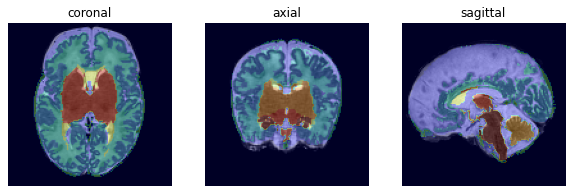

iteration 0
means [509.15 312.49 347.49 246.52 616.31 319.25 271.07 237.96 275.95]
variances [49567.56  8779.91  4363.68 52109.21 29406.93  5160.56  2013.33  2954.61
  1756.75]
iteration 10
means [582.64 260.4  374.08  73.53 616.41 314.72 264.91 232.78 268.69]
variances [23532.8   1487.76  2309.36  3394.64 25568.99  3540.81  1155.36  2040.46
   995.05]
iteration 20
means [571.85 258.56 373.3   66.38 616.07 314.49 264.89 232.37 268.73]
variances [25789.66  1406.64  2312.21  2692.8  25493.13  3520.88  1147.62  2008.91
   985.64]
iteration 30
means [570.52 258.43 373.24  65.36 616.14 314.47 264.89 232.33 268.7 ]
variances [26088.79  1402.68  2314.26  2599.86 25478.3   3520.25  1146.8   2005.79
   982.86]
iteration 40
means [570.33 258.41 373.23  65.21 616.15 314.47 264.89 232.32 268.7 ]
variances [26132.06  1402.28  2314.51  2586.29 25476.68  3520.21  1146.69  2005.36
   982.36]
Dice = 0.81
Housford distance: 10.82
Average Housedorf distance: 0.29
Dice = 0.87
Housford distance: 7.48
Avera

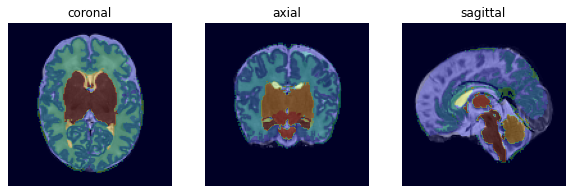

iteration 0
means [544.27 344.86 358.75 261.89 677.89 306.54 371.91 257.85 334.04]
variances [45552.19 16115.92  6834.66 53523.41 29951.6   3898.24 40188.23  8577.69
 17251.97]
iteration 10
means [633.18 279.26 386.4   93.25 775.61 305.95 353.76 243.98 317.87]
variances [14456.22  2733.46  5863.77  5139.21  7845.24  3067.29 32442.36  4019.67
 11619.39]
iteration 20
means [626.99 275.59 386.91  83.23 774.08 305.03 353.79 243.33 318.39]
variances [15696.51  2549.81  5547.92  3904.62  8059.21  3014.34 32429.36  3956.52
 11717.84]
iteration 30
means [626.63 275.41 386.9   82.79 773.67 304.96 353.79 243.29 318.29]
variances [15770.33  2542.36  5533.55  3854.3   8122.08  3010.98 32434.94  3952.8
 11696.18]
iteration 40
means [626.61 275.41 386.9   82.77 773.64 304.96 353.79 243.29 318.28]
variances [15773.31  2542.06  5532.9   3852.43  8126.52  3010.84 32435.29  3952.65
 11694.17]
Dice = 0.81
Housford distance: 9.49
Average Housedorf distance: 0.25
Dice = 0.81
Housford distance: 7.87
Average

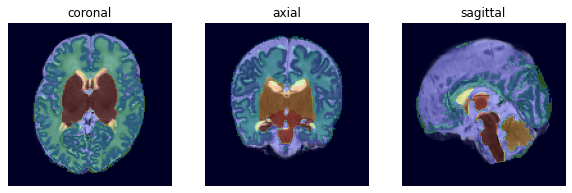

iteration 0
means [502.23 307.47 361.82 228.   534.46 322.65 289.34 250.86 283.95]
variances [42074.32  4669.86  3304.96 38566.39 28794.29  3171.1   2719.27  3785.05
  1756.05]
iteration 10
means [538.68 268.2  383.53 109.71 514.32 320.2  283.95 237.6  272.78]
variances [26781.64   954.98  1295.75  5422.35 26596.55  2473.72  1777.36  1726.41
   727.4 ]
iteration 20
means [532.78 267.3  382.9  105.24 516.03 320.13 283.89 237.44 272.96]
variances [27689.13   912.75  1326.2   5085.25 26522.26  2466.2   1774.21  1711.34
   731.04]
iteration 30
means [532.34 267.24 382.86 104.86 516.15 320.12 283.89 237.43 272.97]
variances [27759.14   910.14  1328.22  5056.81 26517.37  2465.76  1773.98  1710.31
   731.21]
iteration 40
means [532.31 267.24 382.86 104.83 516.16 320.12 283.89 237.43 272.97]
variances [27764.51   909.96  1328.36  5054.55 26517.04  2465.73  1773.97  1710.23
   731.22]
Dice = 0.82
Housford distance: 11.58
Average Housedorf distance: 0.27
Dice = 0.9
Housford distance: 5.1
Average

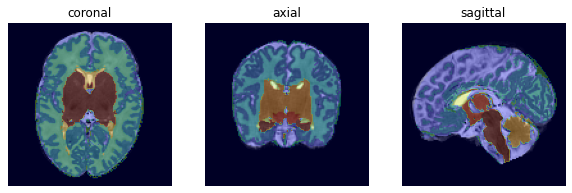

iteration 0
means [526.36 309.72 357.92 218.87 578.19 312.64 279.56 239.74 280.95]
variances [38233.13  6076.78  3606.41 40468.79 29098.49  2514.87  2946.62  1755.46
  2621.98]
iteration 10
means [568.74 267.18 381.33  99.67 576.91 313.37 271.49 235.87 274.3 ]
variances [21212.76  1215.99  1733.42  4298.42 25599.75  2256.49  1632.16  1317.26
  1702.42]
iteration 20
means [565.3  266.46 380.85  97.9  577.31 313.22 271.45 235.65 274.36]
variances [21823.46  1182.88  1749.58  4136.35 25524.9   2250.38  1629.57  1297.51
  1700.77]
iteration 30
means [565.18 266.44 380.83  97.84 577.33 313.21 271.45 235.64 274.36]
variances [21844.59  1181.82  1750.2   4130.82 25522.13  2250.18  1629.48  1296.87
  1700.66]
iteration 40
means [565.18 266.44 380.83  97.84 577.33 313.21 271.45 235.64 274.36]
variances [21845.31  1181.78  1750.22  4130.63 25522.03  2250.18  1629.48  1296.85
  1700.66]
Dice = 0.84
Housford distance: 9.43
Average Housedorf distance: 0.23
Dice = 0.9
Housford distance: 5.74
Average

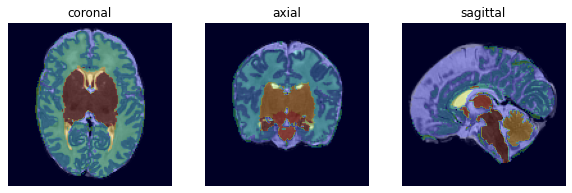

In [33]:
for i, (im, mask, p, lbl) in enumerate(zip(pt_test_im, pt_masks, pt_priors, pt_test_lbl)):
  masked_image = mask_image(im, mask)
  sitk_image_masked = sitk.GetImageFromArray(masked_image)
  sitk_image_masked.CopyInformation(im) 
  input = sitk.GetArrayFromImage(sitk_image_masked)

  prior = [sitk.GetArrayFromImage(i) for i in p]

  seg = gmm_seg(input, im, prior)
  preterm_seg.append(seg)
  for label in range(9):
    reg_seg = extract_region(sitk.GetArrayFromImage(seg), label+1)
    reg_gt = extract_region(sitk.GetArrayFromImage(lbl), label+1)
    preterm_dice[i, label] = Dice(reg_seg, reg_gt)
    hd, ahd = Hausdorff(sitk.GetImageFromArray(reg_seg), sitk.GetImageFromArray(reg_gt))
    preterm_hd[i, label] = hd
    preterm_ahd[i, label] = ahd

  print("Mean dice: ", np.mean(term_dice[i,:]),
        "Mean hausdorff: ", np.mean(term_hd[i,:]),
        "Mean average hausdorff: ", np.mean(term_ahd[i,:]))
  PlotOverlay3D(im, seg, 0.3,c='jet')
  plt.show()

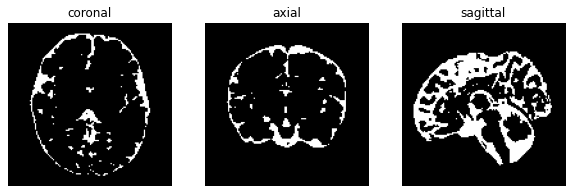

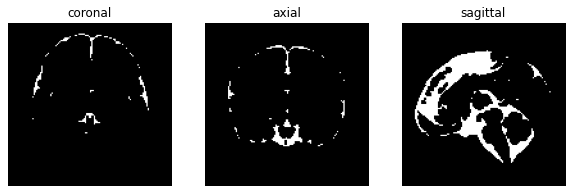

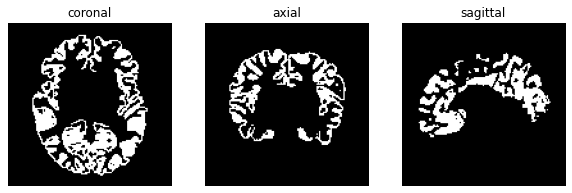

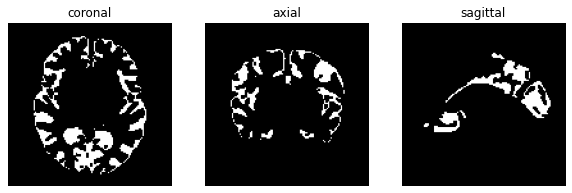

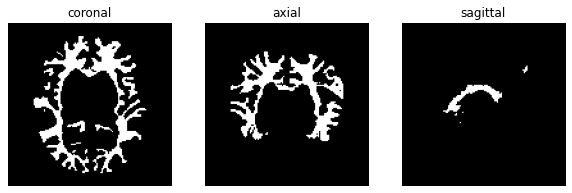

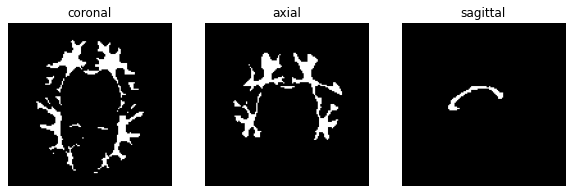

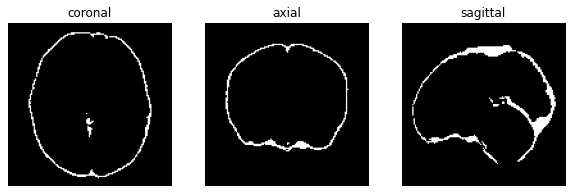

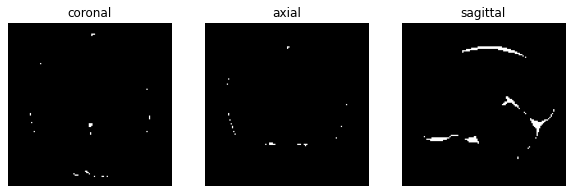

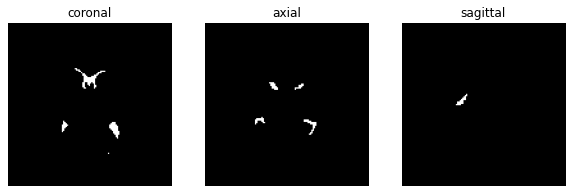

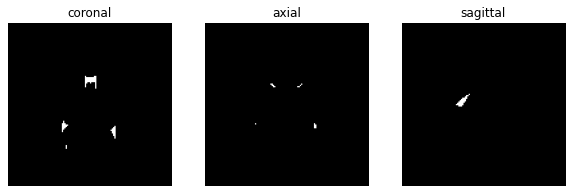

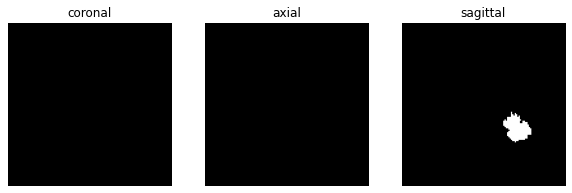

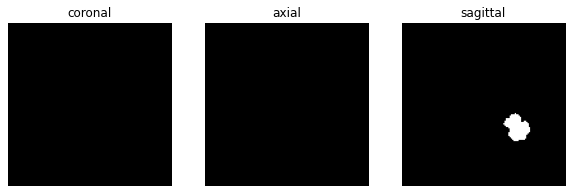

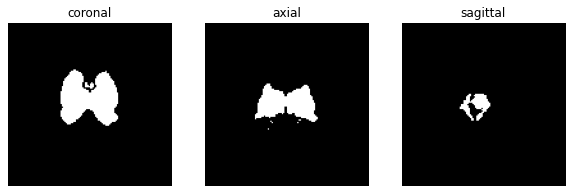

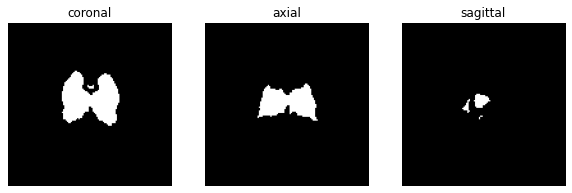

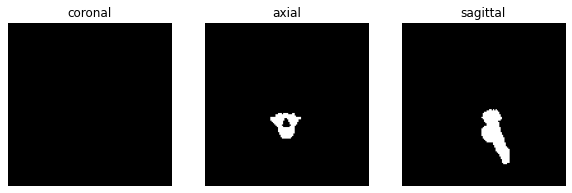

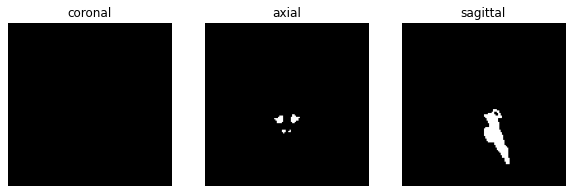

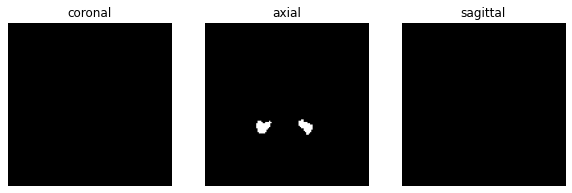

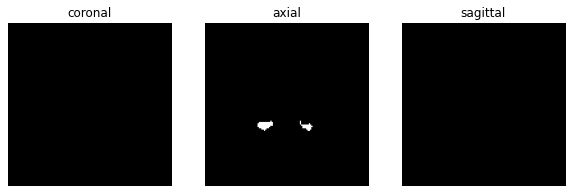

In [38]:
res_lbl = resample_image(t_test_im[1], label_atlas, transformation=t_trans[1])
for i in range(9):
  label = t_test_lbl[1]
  reg = extract_region(sitk.GetArrayFromImage(label), i+1)
  regl = extract_region(sitk.GetArrayFromImage(res_lbl), i+1)
  Display3D(sitk.GetImageFromArray(reg))
  plt.show()
  Display3D(sitk.GetImageFromArray(regl))



__Description [max 100 words]:__ Briefly describe your segmentation approach

Your description here

__Task 1.2__: Perform quantitative evaluation of your segmentation technique against the dHCP labels on the test dataset. Calculate the measures for all labels (with exception of background).

__Description [max 50 words]:__ Comment on quantitative performance of your method

Your description here

__Task 1.3:__ Visualise the segmentations, in three views and also as 3D meshes. 

In [ ]:
# Your code here


__Description [max 50 words]:__ Comment on qualitative performance of your method

Your description here

## Question 2 [40 marks]
#### Implement an alternative segmentation technique for neonatal brain MRI
* It can be __a deep learning technique or a classical technique__ that is __very different__ from the one you used in Question 1. 
* If using deep learning, perform training on the __training__ data and only predict on the __test__ data
* If using a classical technique you can only segment the __test__ dataset
* You will be marked for scientific rigour, performance and originality.

__Task 2.1__: Implement segmentation

In [ ]:
import glob
data_dir = '/content/drive/MyDrive/Part B Assignment'
train_images = sorted(
    glob.glob(os.path.join(data_dir, "training_data", "*", "t2", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "training_data", "*", "labels", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [ ]:
# If using deep learning perform your training here


In [ ]:
# Segment the test dataset here 
# If using deep learning predict on test set
# If using classical method implement the whole pipeline directly on test set here


__Description [max 100 words]:__ Briefly describe your segmentation approach

Your description here

__Task 2.2__: Perform quantitative evaluation of your segmentation technique against the dHCP labels on the test dataset. Calculate the measures for all labels (with exception of background).

In [ ]:
# Your code here


__Description [max 50 words]:__ Comment on quantitative performance of your method

Your description here

__Task 2.3:__ Visualise the segmentations, in three views and also as 3D meshes. 

In [ ]:
# Your code here


__Description [max 50 words]:__ Comment on qualitative performance of your method

Your description here

## Question 3 [20 marks]
#### Analyse the brain development of term and preterm babies. 
* Compare the volumes of brain structures of term and preterm babies
* Visualise in 3D the differences between term and preterm brain
* Train a classifier to predict whether the baby is preterm
* You will be marked for scientific rigour, correct conclusions and performance of the classifier.

__Task 3.1__: Calculate volumes of brain structures of term and preterm babies. For this select the best segmentation technique that you implemented.

In [ ]:
# apply your selected segmentation technique to the whole dataset (training and test)
# if you failed to successfully segment the data or the running time is too long 
# skip this step and use the given dHCP segmentation instead


In [ ]:
# calculate the volumes of different brain structures
# The resolution is 1mmx1mmx1mm so you can just count voxels


__Description [max 50 words]:__ Describe how you segmented the dataset and how you calculated the volumes

Your description here

__Task 3.2:__ Compare the volumes of different brain structures of term and preterm babies. You can use graphs (e.g. boxplots) and/or statistical analysis (e.g. averages, ttests).

In [ ]:
# Your code here


__Description [max 50 words]:__ Describe how the volumes of brain structures differ between term and preterm babies.

Your answer here

__Task 3.3__ Visualise in 3D an example of differences between term and preterm brain. Recommended structures for visualisation are ventricles and cortex.

In [ ]:
# Your code here


__Description [max 50 words]:__ Describe the qualitative differences in brain structure shapes and sizes between term and preterm babies.

Your answer here

__Task 3.4:__ Train a classifier that will predict whether the baby is preterm. Perform your training on the training set and evaluate performance on the test set. You can choose whether you use the volumes as features for your classifier, or whether you predict directly from images. If you go for the second option, you can use the tutorial here https://github.com/Project-MONAI/tutorials/tree/master/3d_classification

In [ ]:
# Train your classifier here


In [ ]:
# Evaluate you classifier here


__Description [max 50 words]:__ Describe your classifier and comment its performance.

Your answer here